In [14]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

In [191]:
def prettify_ax(ax):
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

In [154]:
def normalize(array, startprice=None):
    ''' go from stock price to return; if no startprice given, assume first entry '''
    array = np.array(array)
    init = startprice if startprice is not None else array[0]
    return (array/init) - 1

def denormalize(array, startprice):
    ''' go from return on investment to stock price '''
    return startprice*(array+1)

def load_stock(stock_colnum=1, lookback=50, shuffle_train=True, filename='stocks.csv'):
    ''' load training, validation, and test data for a specific stock '''
    data = pd.read_csv('stocks.csv', usecols=[colnum]).values[:,0]
    X_train, y_train, X_valid, y_valid, X_test, y_test = [], [], [], [], [], []
    for i in range(data.shape[0]-lookback):
        x_curr, y_curr = normalize(data[i:i+lookback]), normalize(data[i+lookback], data[i])
        if i < .6*(data.shape[0]-lookback): #training set, 60%
            X_train.append(x_curr)
            y_train.append(y_curr)
        elif i < .8*(data.shape[0]-lookback): #validation set, 20%
            X_valid.append(x_curr)
            y_valid.append(y_curr)
        else: #test set, 20%
            X_test.append(x_curr)
            y_test.append(y_curr)
    if shuffle_train: #shuffle training set
        idx = range(len(X_train))
        np.random.shuffle(idx)
        X_train = np.array(X_train)[idx,:]
        y_train = np.array(y_train)[idx]
    return np.array(X_train), np.array(y_train), \
           np.array(X_valid), np.array(y_valid), \
           np.array(X_test), np.array(y_test)

# load practice stock, AAPL
lookback = 50
X_train, y_train, X_valid, y_valid, X_test, y_test = load_stock(stock_colnum=1, \
                                                                lookback=lookback, \
                                                                shuffle_train=True)

In [155]:
# build model
model = Sequential()
model.add(LSTM(input_shape=(None,1), units=lookback, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='rmsprop')

In [156]:
# fit model
model.fit(
    X_train.reshape(X_train.shape[0],X_train.shape[1],1),
    y_train,
    batch_size=512,
    nb_epoch=10,
    validation_split=0.05)

Train on 961 samples, validate on 51 samples
Epoch 1/10
961/961 [==============================] - 4s 4ms/step - loss: 0.0158 - val_loss: 0.0022
Epoch 2/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0058
Epoch 3/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 4/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 5/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 6/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 8/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/10
961/961 [==============================] - 

In [202]:
def predict_days(days, model, data):
    predictions = []
    for i in range(days):
        prediction = model.predict(data.reshape(1,lookback,1))[0,0]
        predictions.append(prediction)
        data = np.hstack((data[1:], [prediction]))
    return predictions

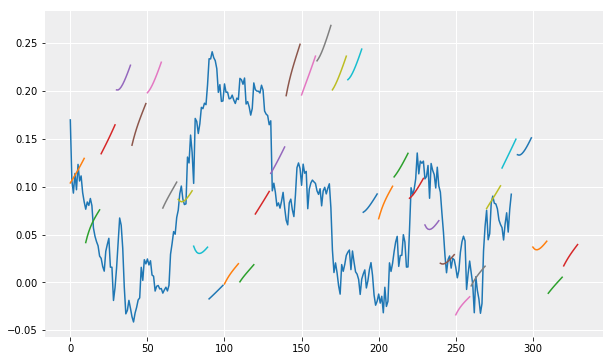

In [214]:
f, a = simple_ax(figsize=(10,6))
a.plot(y_test[lookback:])
for segment in range(int(len(y_test)/days)):
    days = 10
    predictions = predict_days(10, model, X_test[segment*days,:])
    a.plot(range(segment*days, segment*days+days), predictions)
plt.show()

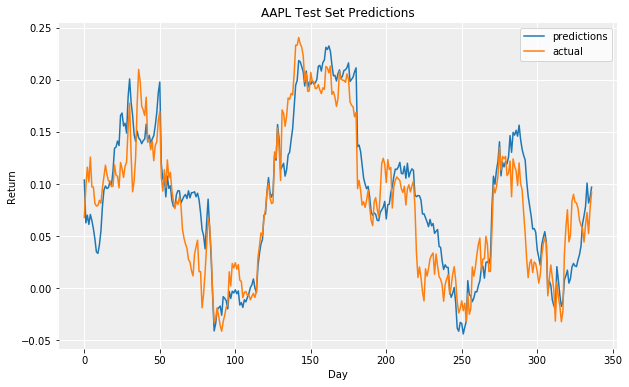

In [192]:
# predict test set
predictions = [model.predict(X_test[a,:].reshape(1,lookback,1))[0,0] for a in range(X_test.shape[0])]
f, a = simple_ax(figsize=(10,6))
a.plot(predictions, label='predictions')
a.plot(y_test, label='actual')
a.set_ylabel('Return')
a.set_xlabel('Day')
a.set_title('AAPL Test Set Predictions')
plt.legend()
plt.show()